### EYE FOR BLIND: An Image Captioning Project

- This notebook is the capstone project for the EPGP program by Upgrad and IIITB. 

- The project, titled "Eye for Blind," focuses on generating descriptive captions for images.

- The implementation is roughly based on the paper: **"Show, Attend and Tell: Neural Image Caption Generation with Visual Attention"**.

### Quick Tech Overview

#### 1. Architecture

* **Encoder**: Inception V3 (top removed) -> extract *mixed7* grid features -> Dense layer projects to common embedding space.
* **Decoder**: LSTM + **Bahdanau Attention** -> attends to image regions each step to predict next word.
* **Attention math**: alignment scores -> weighted context vector -> fed to LSTM with word embed.

#### 2. Training Tricks

* **Feature caching**: save pre-extracted `.npy` files to skip repeat CNN passes.
* **Mixed-precision (AMP)**: `mixed_float16` for speed & lower VRAM.
* **Custom `train_step` (@tf.function)**: fast graph execution, easy add-ons.
* **Gradient clipping**: `tf.clip_by_global_norm` to tame exploding grads.
* **Attention regularizer**: penalty if weights <> 1.0.

#### 3. Data-to-Text Bridging

* **Scheduled sampling**: linearly swap teacher forcing -> self-feeding to cut exposure bias.
* **Beam search (inference)**: keeps top-*k* partial captions + length penalty for balanced outputs.

#### 4. Training Management

* **Early stopping**: halt when val BLEU-4 stalls (patience configurable).

#### 5. Evaluation & Explainability

* **Metrics**: BLEU-1/2/3/4 + timing stats.
* **Attention heat-maps**: visualize focus per generated word.
* **EDA helpers**: caption length histos, word freq, sample previews.
* **Optional TTS**: gTTS turns captions into audio.

---

Result: a lean, cache-efficient, attention-guided captioner that’s fast to train, interpretable, and yields high-quality descriptions.


In [1]:
import os, re, time, random, collections, tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from gtts import gTTS
from IPython.display import Audio, display

###  CONFIGURATION

In [2]:
CONFIG: Dict[str, object] = {
    # Directory containing image files
    'image_dir': '/home/flickr8k/Images',
    
    # Path to the captions file
    'caption_file': '/home/flickr8k/captions.txt',
    
    # Directory to cache extracted image features
    'feature_cache_dir': '/home/flickr8k/cache',
    
    # Number of examples to use (None means use all)
    'num_examples': None,
    
    # Maximum length of captions (in tokens)
    'max_caption_length': 50,
    
    # Minimum word frequency for vocabulary pruning
    'min_word_frequency': 5,

    # Embedding dimension for the model
    'embedding_dim': 256,
    
    # Number of units in LSTM
    'units': 512,
    
    # Dropout rate for the decoder
    'decoder_dropout': 0.5,

    # Learning rate for the optimizer
    'learning_rate': 5e-5,
    
    # Number of training epochs
    'epochs': 30,
    
    # Batch size for training
    'batch_size': 64,

    # Buffer size for shuffling the dataset
    'buffer_size': 1000,
    
    # Early stopping patience
    'patience': 5,
    
    # Path to save model checkpoints
    'checkpoint_path': './checkpoints/lstm_attention_flickr8k',
    
    # Enable mixed precision training for faster computation
    'mixed_precision': True,

    # Regularization weight for attention alignment
    'attention_reg_lambda': 0.5,
    
    # Gradient clipping value to prevent exploding gradients
    'grad_clip_value': 5.0,
    
    # Maximum probability for scheduled sampling
    'scheduled_sampling_max_prob': 0.2,
    
    # Random seed for reproducibility
    'seed': 42,
}

###  ENV SETUP

In [3]:
# Set random seeds for reproducibility
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# Enable mixed precision training if configured
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("[AMP] mixed_float16 policy active")
else:
    print("[AMP] disabled - using float32 throughout")

# Configure GPU memory growth to prevent memory allocation issues
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using GPU: {physical_devices[0].name} | batch={CONFIG['batch_size']}")
else:
    print("GPU not found - fallback to CPU")

# Set AUTOTUNE for optimizing data pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 6000 Ada Generation, compute capability 8.9
[AMP] mixed_float16 policy active
Using GPU: /physical_device:GPU:0 | batch=64


###  DATA LOADING AND PREPROCESSING

In [4]:
class DataProcessor:
    """
    Handles loading, preprocessing, and splitting of image-caption data for image captioning.
    - Loads captions and images, checks for missing files.
    - Preprocesses captions (lowercase, remove non-alpha, add tokens).
    - Builds tokenizer and prunes vocab by min_word_frequency.
    - Splits data into train/val/test and pairs images with padded caption sequences.
    - Supports mapping to cached image features.
    - Can display random samples with captions for sanity check.
    """

    def __init__(self, config):
        # Store config and initialize all data structures
        self.config = config
        self.tokenizer: Optional[Tokenizer] = None
        self.img_to_cap_map: Dict[str, List[str]] = collections.defaultdict(list)
        self.image_paths: List[str] = []
        self.all_captions: List[str] = []
        self.train_data: List[Tuple[str, List[int]]] = []
        self.val_data: List[Tuple[str, List[int]]] = []
        self.test_data: List[Tuple[str, List[int]]] = []
        self.max_caption_length = 0
        self.vocab_size = 0
        self.num_steps_per_epoch = 0

    def load_and_preprocess_data(self):
        """
        Loads captions from CSV, checks image existence, preprocesses captions,
        builds tokenizer, prunes vocab, and computes max caption length.
        """
        print("Loading and preprocessing captions...")
        df = pd.read_csv(self.config['caption_file'], engine='python')
        df['image'] = df['image'].str.strip()
        df['caption'] = df['caption'].str.strip()

        temp_img_to_cap_map = collections.defaultdict(list)
        all_unique_img_names_from_csv = df['image'].unique()

        print(f"Checking {len(all_unique_img_names_from_csv)} unique image files from CSV...")
        found_images_count = 0
        
        existing_image_files = set(os.listdir(self.config['image_dir']))

        for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="Validating images & processing captions"):
            img_name = row['image']
            caption = row['caption']
            
            if img_name in existing_image_files:
                temp_img_to_cap_map[img_name].append(self.preprocess_text(caption))
                if img_name not in self.img_to_cap_map:
                    found_images_count += 1
                self.img_to_cap_map[img_name] = temp_img_to_cap_map[img_name]
            
        if found_images_count < len(all_unique_img_names_from_csv):
            print(f"Warning: {len(all_unique_img_names_from_csv) - found_images_count} images mentioned in CSV were not found in {self.config['image_dir']}. They have been discarded.")
        
        self.image_paths = sorted(list(self.img_to_cap_map.keys()))

        if self.config['num_examples']:
            if len(self.image_paths) > self.config['num_examples']:
                self.image_paths = random.sample(self.image_paths, self.config['num_examples'])
                self.img_to_cap_map = {img: self.img_to_cap_map[img] for img in self.image_paths}
                print(f"Using a subset of {len(self.image_paths)} images due to 'num_examples' config.")

        self.all_captions = []
        for img_name in self.image_paths:
            self.all_captions.extend(self.img_to_cap_map[img_name])

        print(f"Total valid images (with captions): {len(self.image_paths)}")
        print(f"Total valid captions: {len(self.all_captions)}")

        # Build tokenizer and prune vocab
        self.tokenizer = Tokenizer(num_words=None, oov_token="<unk>",
                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                   lower=True)
        self.tokenizer.fit_on_texts(self.all_captions)

        word_counts = collections.Counter(word for caption in self.all_captions for word in caption.split())
        filtered_word_index = {
            word: index for word, index in self.tokenizer.word_index.items()
            if word_counts[word] >= self.config['min_word_frequency'] or word in ['<pad>', '<start>', '<end>', '<unk>']
        }
        self.tokenizer.word_index = filtered_word_index
        self.tokenizer.index_word = {v: k for k, v in filtered_word_index.items()}

        if '<pad>' not in self.tokenizer.word_index:
            self.tokenizer.word_index['<pad>'] = len(self.tokenizer.word_index) + 1
            self.tokenizer.index_word[len(self.tokenizer.index_word) + 1] = '<pad>'
            
        self.vocab_size = len(self.tokenizer.word_index) + 1
        print(f"Vocabulary size after pruning (min_word_frequency={self.config['min_word_frequency']}): {self.vocab_size}")

        all_seqs = self.tokenizer.texts_to_sequences(self.all_captions)
        self.max_caption_length = max(len(s) for s in all_seqs)
        self.config['max_caption_length'] = self.max_caption_length
        print(f"Max caption length: {self.max_caption_length}")
        
    def preprocess_text(self, caption: str) -> str:
        """
        Lowercases, removes non-alpha chars, trims, and adds <start>/<end> tokens.
        """
        caption = caption.lower()
        caption = re.sub(r"[^a-z ]", "", caption)
        caption = re.sub(r'\s+', ' ', caption).strip()
        caption = '<start> ' + caption + ' <end>'
        return caption

    def create_dataset_splits(self, train_ratio=0.8, val_ratio=0.1):
        """
        Shuffles and splits image paths into train/val/test, then pairs with captions.
        """
        random.shuffle(self.image_paths)
        num_images = len(self.image_paths)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)

        train_image_paths = self.image_paths[:num_train]
        val_image_paths = self.image_paths[num_train:num_train + num_val]
        test_image_paths = self.image_paths[num_train + num_val:]

        print(f"Train images: {len(train_image_paths)}, Val images: {len(val_image_paths)}, Test images: {len(test_image_paths)}")

        self.train_data = self._create_pairs(train_image_paths)
        self.val_data = self._create_pairs(val_image_paths)
        self.test_data = self._create_pairs(test_image_paths)

        print(f"Train pairs: {len(self.train_data)}, Val pairs: {len(self.val_data)}, Test pairs: {len(self.test_data)}")

        self.num_steps_per_epoch = len(self.train_data) // self.config['batch_size']

    def _create_pairs(self, image_names: List[str]) -> List[Tuple[str, List[int]]]:
        """
        For each image, pairs it with all its captions (as padded int sequences).
        """
        pairs = []
        for img_name in image_names:
            full_img_path = os.path.join(self.config['image_dir'], img_name)
            for caption in self.img_to_cap_map[img_name]:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                padded_seq = pad_sequences([seq], maxlen=self.max_caption_length, padding='post')[0]
                pairs.append((full_img_path, list(padded_seq)))
        return pairs

    def get_data_with_cached_features(self, image_name_to_cached_path_map: Dict[str, str]) -> Tuple[List, List, List]:
        """
        Replaces image paths with cached feature paths if available, for all splits.
        Only keeps pairs where cached features exist.
        """
        def _reconstruct_list(data_list):
            reconstructed = []
            for original_img_path, caption_ids in data_list:
                basename = os.path.basename(original_img_path)
                cached_path = image_name_to_cached_path_map.get(basename)
                if cached_path and os.path.exists(cached_path): # Added check if cached file actually exists
                    reconstructed.append((original_img_path, cached_path, caption_ids))
            return reconstructed

        final_train = _reconstruct_list(self.train_data)
        final_val = _reconstruct_list(self.val_data)
        final_test = _reconstruct_list(self.test_data)

        print(f"Adjusted train pairs (after feature caching check): {len(final_train)}")
        print(f"Adjusted val pairs (after feature caching check): {len(final_val)}")
        print(f"Adjusted test pairs (after feature caching check): {len(final_test)}")
        
        return final_train, final_val, final_test

    def display_samples(self, num_samples: int = 5):
        """
        Randomly picks a few images and displays them with their ground truth captions.
        Useful for sanity check of data loading and preprocessing.
        """
        print(f"\n--- Displaying {num_samples} Random Dataset Samples ---")

        # Get a list of all image paths that have associated captions
        available_image_paths = sorted(list(self.img_to_cap_map.keys()))

        if not available_image_paths:
            print("No image paths with captions available to display.")
            return

        # Randomly select a few image names
        samples_to_display = random.sample(available_image_paths, min(num_samples, len(available_image_paths)))

        for i, img_name in enumerate(samples_to_display):
            full_image_path = os.path.join(self.config['image_dir'], img_name)

            if not os.path.exists(full_image_path):
                print(f"Warning: Image file not found for {img_name} at {full_image_path}. Skipping.")
                continue

            print(f"\n--- Sample {i+1}/{num_samples} ---")
            print(f"Image Name: {img_name}")

            try:
                img = Image.open(full_image_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.title(f"Image: {img_name}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error loading or displaying image {img_name}: {e}")
                continue

            gt_captions = self.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    # Clean up <start> and <end> tokens for display
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

    def plot_caption_length_histogram(self):
        caption_lengths = [len(s.split()) for s in self.all_captions]
        plt.figure(figsize=(10, 6))
        plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 2), edgecolor='black')
        plt.title('Histogram of Caption Lengths')
        plt.xlabel('Caption Length (words)')
        plt.ylabel('Number of Captions')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    def plot_top_words(self, top_n: int = 20):
        words = [word for caption in self.all_captions for word in caption.split() 
                if word not in ['<start>', '<end>', '<pad>', '<unk>']]
        word_counts = collections.Counter(words)
        top_words = word_counts.most_common(top_n)
        words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Frequency', y='Word', data=words_df, hue=None, legend=False, palette='viridis')
        plt.title(f'Top {top_n} Most Frequent Words (excluding special tokens)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.show()

    def plot_sample_images_with_caption(self, num_images: int = 6):
        selected_images = random.sample(self.image_paths, min(num_images, len(self.image_paths)))
        
        fig, axes = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns for 6 images
        axes = axes.flatten()

        for i, img_name in enumerate(selected_images):
            full_path = os.path.join(self.config['image_dir'], img_name)
            if not os.path.exists(full_path):
                print(f"Warning: Image {img_name} not found. Skipping.")
                continue

            try:
                img = Image.open(full_path)
                ax = axes[i]
                ax.imshow(img)
                ax.set_title(f"{img_name}\nCap: {self.img_to_cap_map[img_name][0].replace('<start>','').replace('<end>','').strip()}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                axes[i].set_title("Image Load Error")
                axes[i].axis('off')
                continue

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

###  IMAGE FEATURE EXTRACTION (CACHE FEATURES)

In [5]:
class ImageFeatureExtractor(Model):
    """
    Extracts image features using a pre-trained InceptionV3 model.
    - Resizes images to target size and preprocesses them for InceptionV3.
    - Extracts features from the 'mixed7' layer of the model.
    """

    def __init__(self, target_size=(299, 299)):
        """
        Initializes the feature extractor with InceptionV3.
        - Freezes the model to prevent training.
        - Extracts features from the 'mixed7' layer.
        """
        super().__init__()
        self.target_size = target_size
        self.inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        self.inception_v3.trainable = False  # Freeze the model
        self.feature_extractor = Model(inputs=self.inception_v3.input,
                                       outputs=self.inception_v3.get_layer('mixed7').output)

    @tf.function
    def load_and_preprocess_image(self, image_path: tf.Tensor) -> tf.Tensor:
        """
        Loads and preprocesses an image for feature extraction.
        - Reads the image from the given path.
        - Decodes and resizes it to the target size.
        - Applies InceptionV3 preprocessing.
        """
        img = tf.io.read_file(image_path)  # Read image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
        img = tf.image.resize(img, self.target_size)  # Resize to target size
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # Preprocess for InceptionV3
        return img

In [6]:
class ImageFeatureCacheManager:
    """
    Manages extraction and caching of image features using a pre-trained CNN.
    
    Extracts features from the 'mixed7' layer of InceptionV3 and saves them as .npy files
    for faster training. Features are reshaped to (289, 768) representing 17x17 spatial
    locations with 768-dimensional feature vectors.
    """
    
    def __init__(self, config, feature_extractor: ImageFeatureExtractor):
        self.config = config
        self.feature_extractor = feature_extractor
        self.cache_dir = config['feature_cache_dir']
        os.makedirs(self.cache_dir, exist_ok=True)

    def manage_feature_cache(self, image_names: List[str]) -> Dict[str, str]:
        """
        Checks for existing cached features and extracts new ones if needed.
        
        Processes images in batches to efficiently extract CNN features using GPU.
        Returns mapping from image names to their corresponding cache file paths.
        Skips images that fail feature extraction to avoid training errors.
        """
        print(f"\nManaging image feature cache in: {self.cache_dir}")
        print(f"Checking/extracting features for {len(image_names)} unique images.")

        image_name_to_cached_path = {}
        images_to_extract = []

        # Check which images need feature extraction
        for img_name in image_names:
            cache_file = os.path.join(self.cache_dir, img_name + '.npy')
            if not os.path.exists(cache_file):
                images_to_extract.append(img_name)
            image_name_to_cached_path[img_name] = cache_file

        if images_to_extract:
            print(f"Found {len(images_to_extract)} images whose features need extraction...")
            
            full_paths_for_extraction = [os.path.join(self.config['image_dir'], img_name) for img_name in images_to_extract]

            batch_size_extraction = 16 # Adjust based on your GPU memory
            for i in tqdm.tqdm(range(0, len(full_paths_for_extraction), batch_size_extraction), desc="Extracting & Caching Features"):
                batch_paths = full_paths_for_extraction[i:i+batch_size_extraction]
                
                try:
                    # Preprocess images and extract features in batch
                    img_tensors_processed = tf.stack([self.feature_extractor.load_and_preprocess_image(tf.constant(p)) for p in batch_paths])
                    
                    features_batch = self.feature_extractor.feature_extractor(img_tensors_processed)
                    
                    # Reshape to (batch_size, 17*17, 768) for attention mechanism
                    features_flat_batch = tf.reshape(features_batch, (tf.shape(features_batch)[0], -1, tf.shape(features_batch)[3]))
                    
                    # Save features for each image separately
                    for j, img_path in enumerate(batch_paths):
                        img_name = os.path.basename(img_path)
                        cache_path = os.path.join(self.cache_dir, img_name + '.npy')
                        # Save each image's features separately as (289, 768)
                        np.save(cache_path, features_flat_batch[j].numpy())
                except Exception as e:
                    print(f"\nError processing a batch during feature extraction: {e}. Skipping images in this batch.")
                    # Remove failed images from the mapping to prevent training issues
                    for img_path_in_batch in batch_paths:
                        img_name_in_batch = os.path.basename(img_path_in_batch)
                        # Remove from map if feature extraction failed, so it's not used
                        if img_name_in_batch in image_name_to_cached_path:
                            del image_name_to_cached_path[img_name_in_batch]
                    continue
        else:
            print("All image features already cached. Skipping extraction.")
            
        print("Image feature cache management complete.")
        return image_name_to_cached_path

###  MODEL ARCHITECTURE

In [7]:
class Encoder(Model):
    """
    Encoder transforms CNN features to embedding space for the decoder.
    Uses a fully connected layer to project image features to embedding dimension.
    """
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        # Project image features to embedding dimension
        x = self.fc(x)
        return x

class BahdanauAttention(layers.Layer):
    """
    Bahdanau attention mechanism for focusing on relevant image regions.
    Computes attention weights using additive attention with tanh activation.
    Returns context vector and attention weights for visualization.
    """
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # Dense layers for computing attention scores
        self.W1 = layers.Dense(units)  # Transform features
        self.W2 = layers.Dense(units)  # Transform hidden state
        self.V = layers.Dense(1)       # Final attention score

    def call(self, features, hidden):
        # Add time dimension to hidden state for broadcasting
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # Compute attention scores using additive attention
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        # Convert scores to probabilities
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # Compute weighted sum of features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, tf.squeeze(attention_weights, -1)

class Decoder(Model):
    """
    LSTM-based decoder with attention for generating captions word by word.
    Takes embedded words and attended image features to predict next word.
    Handles mixed precision training by casting states to appropriate dtype.
    """
    def __init__(self, embedding_dim, units, vocab_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.units = units
        
        # Word embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        
        # LSTM with dropout for regularization
        self.lstm = layers.LSTM(self.units,
                                 return_sequences=True,
                                 return_state=True,
                                 recurrent_initializer='glorot_uniform',
                                 dropout=dropout)

        # Dense layers for output projection
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size, dtype='float32')  # Always float32 for stable logits

        # Attention mechanism
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden_state, cell_state):
        # Get context vector from attention
        context_vector, attention_weights = self.attention(features, hidden_state)

        # Embed input word
        x = self.embedding(x)

        # Concatenate context and embedded word
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Handle mixed precision by casting to float16 if needed
        if tf.keras.mixed_precision.global_policy().compute_dtype == 'float16':
            hidden_state = tf.cast(hidden_state, tf.float16)
            cell_state = tf.cast(cell_state, tf.float16)
            x = tf.cast(x, tf.float16)

        # Pass through LSTM
        output, new_hidden_state, new_cell_state = self.lstm(x, initial_state=[hidden_state, cell_state])

        # Flatten for dense layer
        output = tf.reshape(output, (-1, output.shape[2]))

        # Project to vocabulary size
        x = self.fc1(output)
        logits = self.fc2(x)

        return logits, new_hidden_state, new_cell_state, attention_weights

###  TEXT-TO-SPEECH UTILITY

In [8]:
class TextToSpeech:
    """
    Simple wrapper around gTTS (Google Text-to-Speech) for audio playback in Jupyter.
    Handles import errors gracefully and provides audio generation for generated captions.
    """
    
    def __init__(self):
        try:
            self.gTTS = gTTS
            self.Audio = Audio
            self.display = display
            self.available = True
        except ImportError:
            print("WARNING: gTTS or IPython.display not found. Speech functionality will be disabled.")
            self.available = False

    def speak(self, text: str, filename: str = "caption_audio.mp3"):
        """
        Converts text to speech and plays audio in Jupyter notebook.
        Saves audio file locally and uses IPython.display.Audio for playback.
        """
        if not self.available:
            print("Text-to-speech functionality is not available. Please install 'gtts' and ensure running in an IPython environment.")
            return
        
        if not text.strip():
            print("Empty text, nothing to speak.")
            return
        
        try:
            # Generate speech audio file
            tts = self.gTTS(text=text, lang='en')
            tts.save(filename)
            # Play audio in notebook
            self.display(self.Audio(filename))
            print(f"Audio saved to {filename} and played.")
        except Exception as e:
            print(f"Error generating or playing audio: {e}")

###  TRAINING LOOP & UTILITIES

In [9]:
class ImageCaptioning:
    """
    Main image captioning model that combines encoder-decoder architecture with attention mechanism.
    Uses pre-extracted image features and generates captions using greedy search or beam search.
    Includes training loop with early stopping, BLEU evaluation, and visualization capabilities.
    """
    
    def __init__(self, config, processor: DataProcessor, feature_extractor: ImageFeatureExtractor):
        """Initialize the image captioning model with encoder, decoder, optimizer and checkpoint management."""
        self.config = config
        self.processor = processor
        self.feature_extractor = feature_extractor

        # Core model components
        self.encoder = Encoder(self.config['embedding_dim'])
        self.decoder = Decoder(self.config['embedding_dim'], self.config['units'],
                               self.processor.vocab_size, self.config['decoder_dropout'])

        # Optimizer setup with optional mixed precision
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        if self.config['mixed_precision']:
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(self.optimizer)

        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

        # Checkpoint management
        self.checkpoint_prefix = os.path.join(self.config['checkpoint_path'], "ckpt")
        self.checkpoint = tf.train.Checkpoint(encoder=self.encoder,
                                             decoder=self.decoder,
                                             optimizer=self.optimizer)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.config['checkpoint_path'], max_to_keep=5)

        self.tts_speaker = TextToSpeech()

        # Training metrics and early stopping
        self.train_loss_results = []
        self.val_bleu_results = []
        self.best_val_bleu = 0.0
        self.smoothing_function = SmoothingFunction().method4
        self.patience_counter = 0

        # Restore from checkpoint if available
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f"Restored from {self.checkpoint_manager.latest_checkpoint}")
        else:
            print("Initializing from scratch.")

    def loss_function(self, real, pred):
        """Calculate masked loss that ignores padded tokens (0)."""
        mask = tf.math.logical_not(tf.math.equal(real, 0)) # Mask out padded tokens (0)
        loss_ = self.loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    def evaluate_bleu_score(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples=None):
        """
        Evaluate model performance using BLEU scores (1-4).
        Uses beam search inference and compares against multiple reference captions.
        """
        references = []
        hypotheses = []

        if num_samples is None:
            samples_to_evaluate = dataset_pairs
        else:
            samples_to_evaluate = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        print(f"\nEvaluating BLEU on {len(samples_to_evaluate)} samples...")
        for img_path, _ in tqdm.tqdm(samples_to_evaluate):
            # Try greedy inference first
            generated_caption_tokens = self.greedy_inference(img_path)
            
            # Fallback to beam search if greedy fails or produces empty string, or if it's generally preferred
            if not generated_caption_tokens: # Can replace with `if True:` to always use beam search
                generated_caption_tokens, _ = self.beam_search_inference(img_path, beam_size=3)

            if not generated_caption_tokens:
                continue # Skip if no caption could be generated

            hypotheses.append(generated_caption_tokens)

            # Get reference captions for this image
            img_name = os.path.basename(img_path)
            raw_captions = self.processor.img_to_cap_map.get(img_name, [])
            
            img_references = []
            for raw_cap in raw_captions:
                # Remove <start> and <end> tokens for BLEU calculation
                cleaned_cap = raw_cap.replace('<start>', '').replace('<end>', '').strip()
                if cleaned_cap:
                    img_references.append(cleaned_cap.split())
            
            if img_references:
                references.append(img_references)
            else:
                # If no valid reference captions, remove the corresponding hypothesis
                hypotheses.pop()

        if not references:
            print("No valid reference captions found for BLEU evaluation after filtering.")
            return {"bleu-1": 0.0, "bleu-2": 0.0, "bleu-3": 0.0, "bleu-4": 0.0}

        # Calculate BLEU scores for n-grams 1-4
        bleu_scores = {}
        for n in range(1, 5):
            weights = (1.0 / n,) * n + (0.0,) * (4 - n)
            bleu_scores[f"bleu-{n}"] = corpus_bleu(references, hypotheses, weights=weights,
                                                   smoothing_function=self.smoothing_function)
            print(f"BLEU-{n}: {bleu_scores[f'bleu-{n}']:.4f}")
            
        return bleu_scores

    def greedy_inference(self, image_path: str):
        """
        Generate caption using greedy search - always picks the most probable next word.
        Faster than beam search but may produce suboptimal captions.
        """
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return []

        # Load cached image features
        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32) # Always load as float32
        img_features_tensor = tf.expand_dims(img_features_tensor, 0) # Shape: (1, 289, 768)

        features = self.encoder(img_features_tensor) # Encoder output: (1, 289, embedding_dim)

        # Initialize decoder hidden states
        hidden = tf.zeros((1, self.config['units']), dtype=tf.float32)
        cell = tf.zeros((1, self.config['units']), dtype=tf.float32)

        dec_input = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0) # Shape: (1, 1)

        result = []
        for i in range(self.config['max_caption_length']):
            predictions, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell)
            predicted_id = tf.argmax(predictions[0]).numpy() # predictions[0] converts from (1, vocab_size) to (vocab_size,)
            predicted_word = self.processor.tokenizer.index_word.get(predicted_id, '<unk>')

            if predicted_word == '<end>':
                break
            # Only append valid words, not special tokens
            if predicted_word not in ('<unk>', '<start>', '<pad>'):
                result.append(predicted_word)

            dec_input = tf.expand_dims([predicted_id], 0) # Next input for decoder: (1, 1)

        return result

    def beam_search_inference(self, image_path: str, beam_size: int = 3, length_penalty_weight: float = 0.7):
        """
        Generate caption using beam search - maintains multiple candidate sequences.
        Explores more possibilities than greedy search for potentially better captions.
        Returns best caption and attention weights for visualization.
        """
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return [], []

        # Load and prepare image features
        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
        img_features_tensor = tf.expand_dims(img_features_tensor, 0)

        features = self.encoder(img_features_tensor)

        start_token = self.processor.tokenizer.word_index['<start>']
        end_token = self.processor.tokenizer.word_index['<end>']

        # Each beam is (sequence_of_token_ids, log_probability, hidden_state, cell_state, list_of_attention_weights)
        beams = [(
            [start_token],
            0.0,
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            []
        )]

        completed_beams = []

        # Generate sequences step by step
        for _ in range(self.config['max_caption_length']):
            new_beams = []
            for seq, score, hidden, cell, alphas in beams:
                last_token = seq[-1]

                # Move completed sequences to completed_beams
                if last_token == end_token:
                    completed_beams.append((seq, score, alphas))
                    continue

                dec_input = tf.expand_dims([last_token], 0)
                
                predictions, new_hidden, new_cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                predictions = tf.cast(predictions[0], tf.float32)
                log_probs = tf.nn.log_softmax(predictions).numpy()

                # Keep top k candidates for each beam
                top_k_indices = np.argsort(log_probs)[::-1][:beam_size]

                for idx in top_k_indices:
                    token_id = int(idx)
                    token_log_prob = float(log_probs[idx])
                    
                    new_beams.append((
                        seq + [token_id],
                        score + token_log_prob,
                        new_hidden,
                        new_cell,
                        alphas + [attention_weights[0].numpy()]
                    ))
            
            # Sort beams by score with length penalty
            combined_beams = completed_beams + new_beams
            combined_beams.sort(key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0), reverse=True)
            beams = combined_beams[:beam_size]
            
            # Separate active and completed beams
            final_active_beams = []
            for item in beams:
                if len(item) == 5: # It's an active beam
                    seq, score, _, _, alphas = item
                    if seq[-1] != end_token:
                        final_active_beams.append((seq, score, alphas))
                elif len(item) == 3: # It's already a completed beam
                    completed_beams.append(item) # Re-add it if it was previously considered completed

            temp_active_beams = []
            for seq, score, hidden, cell, alphas in new_beams: # This `new_beams` contains 5-tuples from current step
                if seq[-1] == end_token:
                    completed_beams.append((seq, score, alphas))
                else:
                    temp_active_beams.append((seq, score, hidden, cell, alphas))

            # Select top K from the current pool of active beams and sort them.
            # This ensures `beams` always contains 5-element tuples.
            temp_active_beams.sort(key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0), reverse=True)
            beams = temp_active_beams[:beam_size]

            # Early stopping check: if all top K beams are completed, we can stop
            if all(b[0][-1] == end_token for b in beams):
                completed_beams.extend([(b[0], b[1], b[4]) for b in beams]) # Add remaining completed ones
                break

        # Add any remaining incomplete beams to completed
        completed_beams.extend([(seq, score, alphas) for seq, score, hidden, cell, alphas in beams if seq[-1] != end_token])

        if not completed_beams:
            return [], []

        # Select the best beam (highest score with length penalty) from completed_beams
        best_seq, best_score, best_alphas = max(completed_beams, key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0))

        # Convert token IDs to words and filter out special tokens
        caption_words = [self.processor.tokenizer.index_word.get(i, '<unk>') for i in best_seq]
        
        filtered_caption_words = [
            word for word in caption_words
            if word not in ['<start>', '<end>', '<pad>', '<unk>']
        ]

        return filtered_caption_words, best_alphas

    def plot_history(self):
        """Plot training loss and validation BLEU scores over epochs."""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_results, label='Train Loss')
        plt.title('Training Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.val_bleu_results, label='Validation BLEU-4')
        plt.title('Validation BLEU-4 Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4 Score')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_attention(self, image_path: str, caption: List[str], alphas: List[np.ndarray]):
        """
        Visualize attention weights overlaid on the image for each word in the caption.
        Shows where the model focuses when generating each word.
        """
        img = Image.open(image_path)
        img = np.array(img.resize((299, 299)))

        num_words = len(caption)
        cols = min(5, num_words)
        rows = (num_words + cols - 1) // cols

        fig_width = cols * 4
        fig_height = rows * 4 + 2

        fig = plt.figure(figsize=(fig_width, fig_height))
        fig.subplots_adjust(wspace=0.1, hspace=0.3)

        for t in range(num_words):
            if t >= (rows * cols): 
                break
            
            ax = fig.add_subplot(rows, cols, t + 1)
            ax.imshow(img)
            ax.axis('off')

            # Reshape attention weights to spatial grid
            alpha = np.array(alphas[t])
            attention_grid_size = int(np.sqrt(alpha.shape[0]))
            alpha_reshaped = alpha.reshape(attention_grid_size, attention_grid_size)

            # Resize attention map to match image size
            alpha_resized = Image.fromarray(np.uint8(255 * alpha_reshaped)).resize(
                (299, 299), resample=Image.Resampling.BICUBIC
            )
            alpha_resized = np.array(alpha_resized) / 255.0

            # Use a different colormap like 'jet' or 'viridis' for better visibility over dark images.
            # Decrease the alpha value to make the original image more visible underneath.
            ax.imshow(alpha_resized, cmap='jet', alpha=0.4, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=12, color='blue', va='bottom')

        plt.suptitle(f"Attention Map for: {os.path.basename(image_path)}", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate audio file for the caption using text-to-speech."""
        self.tts_speaker.speak(caption, filename)

    @tf.function
    def train_step(self, img_tensor, target):
        """
        Single training step using teacher forcing with optional scheduled sampling.
        Calculates loss with attention regularization and applies gradient clipping.
        """
        batch_size = tf.shape(target)[0]
        loss = 0.0

        # Handle mixed precision data types
        current_policy = tf.keras.mixed_precision.global_policy()
        if current_policy.name == 'mixed_float16':
            initial_state_dtype = tf.float16
        else:
            initial_state_dtype = tf.float32

        # Initialize decoder states
        hidden = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)
        cell = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)

        dec_input = tf.fill([batch_size, 1], self.processor.tokenizer.word_index['<start>'])

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            attention_sum_square_error = tf.constant(0.0, dtype=tf.float32)

            # Process each time step
            for i in tf.range(1, target.shape[1]):
                predictions, hidden, cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                loss += self.loss_function(target[:, i], predictions)

                # Scheduled sampling: mix ground truth and predicted tokens
                if self.config.get('scheduled_sampling_max_prob', 0.0) > 0:
                    random_probs = tf.random.uniform([batch_size], 0, 1, dtype=tf.float32)
                    
                    threshold = tf.fill([batch_size], self.current_scheduled_sampling_prob)
                    
                    use_predicted_mask = random_probs < threshold
                    
                    predicted_ids = tf.argmax(predictions, axis=1, output_type=tf.int32)
                    
                    true_ids = target[:, i]
                    
                    dec_input = tf.where(use_predicted_mask, predicted_ids, true_ids)
                    
                    dec_input = tf.expand_dims(dec_input, 1)
                else:
                    dec_input = tf.expand_dims(target[:, i], 1)

                # Attention regularization - encourage attention weights to sum to 1
                attention_sum_square_error += tf.reduce_mean(
                    tf.square(tf.cast(tf.reduce_sum(attention_weights, axis=1), tf.float32) - 1.0)
                )

            # Calculate total loss with attention regularization
            total_loss = (loss / tf.cast(target.shape[1] - 1, tf.float32))
            total_loss += self.config['attention_reg_lambda'] * attention_sum_square_error / tf.cast(target.shape[1] - 1, tf.float32)

            # Handle mixed precision loss scaling
            if self.config['mixed_precision']:
                scaled_loss = self.optimizer.get_scaled_loss(total_loss)
            else:
                scaled_loss = total_loss

        # Calculate and apply gradients
        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(scaled_loss, trainable_variables)

        if self.config['mixed_precision']:
            gradients = self.optimizer.get_unscaled_gradients(gradients)

        # Gradient clipping to prevent exploding gradients
        gradients, _ = tf.clip_by_global_norm(gradients, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        return total_loss

    def train(self, train_cached_paths: List[Tuple[str, str, List[int]]],
              val_dataset_pairs: List[Tuple[str, List[int]]]):
        """
        Main training loop with early stopping based on validation BLEU score.
        Uses scheduled sampling and evaluates on validation set each epoch.
        """
        
        def _data_generator():
            """Generator for loading cached features and captions."""
            for orig_img_path, cache_path, caption_ids in train_cached_paths:
                features = np.load(cache_path)
                features = tf.cast(features, tf.float32)
                yield features, np.array(caption_ids, dtype=np.int32)

        # Create training dataset
        train_dataset = tf.data.Dataset.from_generator(
            _data_generator,
            output_signature=(
                tf.TensorSpec(shape=(289, 768), dtype=tf.float32),
                tf.TensorSpec(shape=(self.config['max_caption_length'],), dtype=tf.int32)
            )
        )
        train_dataset = train_dataset.shuffle(self.config['buffer_size']).batch(self.config['batch_size'])
        train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

        # Training loop
        for epoch in range(self.config['epochs']):
            start = time.time()
            total_loss = 0

            # Update scheduled sampling probability
            self.current_scheduled_sampling_prob = (
                self.config['scheduled_sampling_max_prob'] * (epoch / max(1, self.config['epochs'] - 1))
            )
            print(f"\nEpoch {epoch+1}/{self.config['epochs']} (Scheduled Sampling Prob: {self.current_scheduled_sampling_prob:.3f})")

            # Calculate steps per epoch
            self.processor.num_steps_per_epoch = len(train_cached_paths) // self.config['batch_size']
            if self.processor.num_steps_per_epoch == 0:
                print("Warning: num_steps_per_epoch is 0. Batch size might be too large or dataset too small. Setting to 1.")
                self.processor.num_steps_per_epoch = 1

            # Train on batches
            for (batch, (img_tensor, target)) in enumerate(train_dataset):
                batch_loss = self.train_step(img_tensor, target)
                total_loss += batch_loss

                if batch % 100 == 0:
                    print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
            
            # Calculate average training loss
            avg_train_loss = total_loss / self.processor.num_steps_per_epoch
            self.train_loss_results.append(avg_train_loss.numpy())
            print(f'Epoch {epoch+1} Loss {avg_train_loss:.4f}')

            # Validation evaluation
            val_bleu_scores = self.evaluate_bleu_score(val_dataset_pairs, num_samples=min(1000, len(val_dataset_pairs)))
            current_val_bleu4 = val_bleu_scores.get('bleu-4', 0.0)
            self.val_bleu_results.append(current_val_bleu4)

            # Early stopping based on BLEU score improvement
            if current_val_bleu4 > self.best_val_bleu:
                self.best_val_bleu = current_val_bleu4
                self.checkpoint_manager.save()
                print(f"Saving checkpoint at epoch {epoch+1} with BLEU-4: {current_val_bleu4:.4f}")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                print(f"BLEU-4 not improved. Patience counter: {self.patience_counter}/{self.config['patience']}")
                if self.patience_counter >= self.config['patience']:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')

    def summary(self):
        """
        Prints the summary of the Encoder and Decoder models.
        Builds the models using dummy input tensors if they haven't been built yet.
        """
        print("\n--- Model Summaries ---")

        # Encoder Model Summary
        print("\nEncoder Model Summary:")
        # Encoder input shape is (batch_size, 289, 768)
        dummy_encoder_input = tf.zeros((1, 289, 768), dtype=tf.float32)
        # Call the encoder once to build it
        _ = self.encoder(dummy_encoder_input)
        self.encoder.summary()

        # Decoder Model Summary
        print("\nDecoder Model Summary:")
        # Decoder's call method signature: call(self, x, features, hidden_state, cell_state)
        # We need to provide dummy tensors for all these arguments to build it.
        # x: (batch_size, 1) for token ID
        # features: (batch_size, 289, embedding_dim)
        # hidden_state: (batch_size, units)
        # cell_state: (batch_size, units)

        batch_size_dummy = 1
        embedding_dim_dummy = self.config['embedding_dim']
        units_dummy = self.config['units']

        dummy_dec_input = tf.zeros((batch_size_dummy, 1), dtype=tf.int32) # Word ID
        dummy_features = tf.zeros((batch_size_dummy, 289, embedding_dim_dummy), dtype=tf.float32)
        dummy_hidden_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
        dummy_cell_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
        
        # Call the decoder once with dummy inputs to build it
        _ = self.decoder(dummy_dec_input, dummy_features, dummy_hidden_state, dummy_cell_state)
        self.decoder.summary()
        
    def demo(self, image_file_name: str):
        """
        Complete demo showing image, ground truth captions, generated caption with attention,
        and text-to-speech audio output.
        """
        full_image_path = os.path.join(self.config['image_dir'], image_file_name)
        
        if not os.path.exists(full_image_path):
            print(f"Error: Image not found at {full_image_path}")
            return

        # Display the image
        img = Image.open(full_image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Image: {image_file_name}")
        plt.axis('off')
        plt.show()

        # Show ground truth captions
        gt_captions = self.processor.img_to_cap_map.get(image_file_name, [])
        print("\nGround Truth Captions:")
        if gt_captions:
            for i, cap in enumerate(gt_captions):
                clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                print(f"  {i+1}. {clean_cap}")
        else:
            print("  No ground truth captions available.")
        
        # Generate caption using beam search
        generated_caption_words, attention_weights = self.beam_search_inference(full_image_path, beam_size=3)
        generated_caption = " ".join(generated_caption_words)
        print(f"\nGenerated Caption (Beam Search): {generated_caption}")

        # Generate audio
        print("\nPlaying generated caption:")
        self.speak_caption(generated_caption, filename=f"caption_audio_{os.path.basename(image_file_name).split('.')[0]}.mp3")

        # Plot attention visualization
        if generated_caption_words and attention_weights:
            self.plot_attention(full_image_path, generated_caption_words, attention_weights)
        else:
            print("Could not generate caption or attention for plotting.")

    def run_predictions(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples: int = 10):
        """
        Loops over N random cases from the dataset, prints ground truth captions and predictions,
        and provides prediction time statistics.

        Args:
            dataset_pairs: A list of (image_path, caption_ids) tuples for the dataset split (e.g., test_data).
            num_samples: The number of random samples to predict and display.
        """
        print(f"\n--- Running Predictions for {num_samples} Random Samples ---")

        if not dataset_pairs:
            print("No data available for prediction samples.")
            return

        samples_to_predict = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        prediction_times = []

        for i, (img_path, _) in enumerate(samples_to_predict):
            img_name = os.path.basename(img_path)
            
            print(f"\n--- Prediction Sample {i+1}/{num_samples} (Image: {img_name}) ---")
            
            # Ground Truth Captions
            gt_captions = self.processor.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

            # Generated Caption and Prediction Time
            start_time = time.perf_counter()
            generated_caption_words, _ = self.beam_search_inference(img_path, beam_size=3)
            end_time = time.perf_counter()
            
            prediction_time = (end_time - start_time) * 1000 # in milliseconds
            prediction_times.append(prediction_time)

            generated_caption = " ".join(generated_caption_words)
            print(f"Generated Caption (Beam Search): {generated_caption}")
            print(f"Prediction Time: {prediction_time:.2f} ms")

        if prediction_times:
            avg_time = np.mean(prediction_times)
            std_time = np.std(prediction_times)
            print(f"\n--- Prediction Statistics ({len(prediction_times)} samples) ---")
            print(f"Average Prediction Time: {avg_time:.2f} ms")
            print(f"Standard Deviation of Prediction Time: {std_time:.2f} ms")
        else:
            print("\nNo predictions were made.")


###  MAIN EXECUTION

#### Load data

In [10]:
processor = DataProcessor(CONFIG)

In [11]:
processor.load_and_preprocess_data()

Loading and preprocessing captions...
Checking 8091 unique image files from CSV...


Validating images & processing captions: 100%|██████████| 40455/40455 [00:00<00:00, 51212.91it/s]


Total valid images (with captions): 8091
Total valid captions: 40455
Vocabulary size after pruning (min_word_frequency=5): 2989
Max caption length: 37


#### Quick EDA

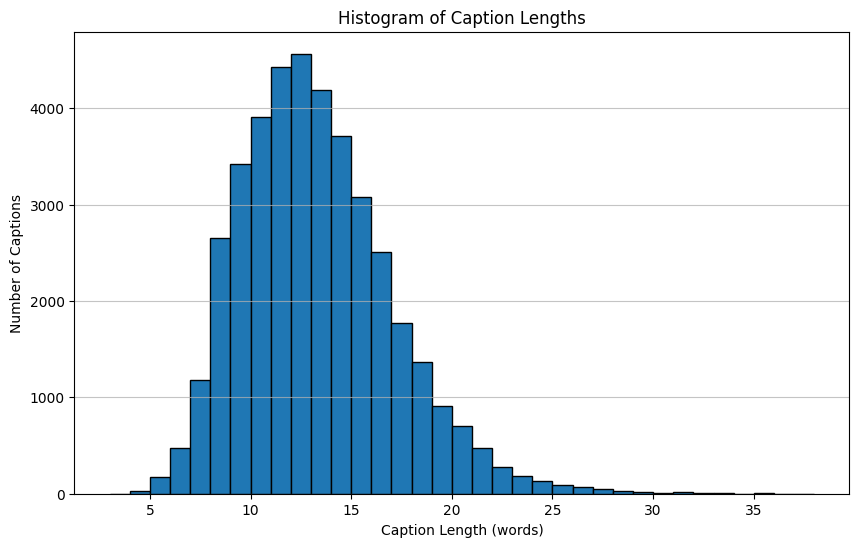

In [12]:
processor.plot_caption_length_histogram()

/tmp/ipykernel_1283/1386974365.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


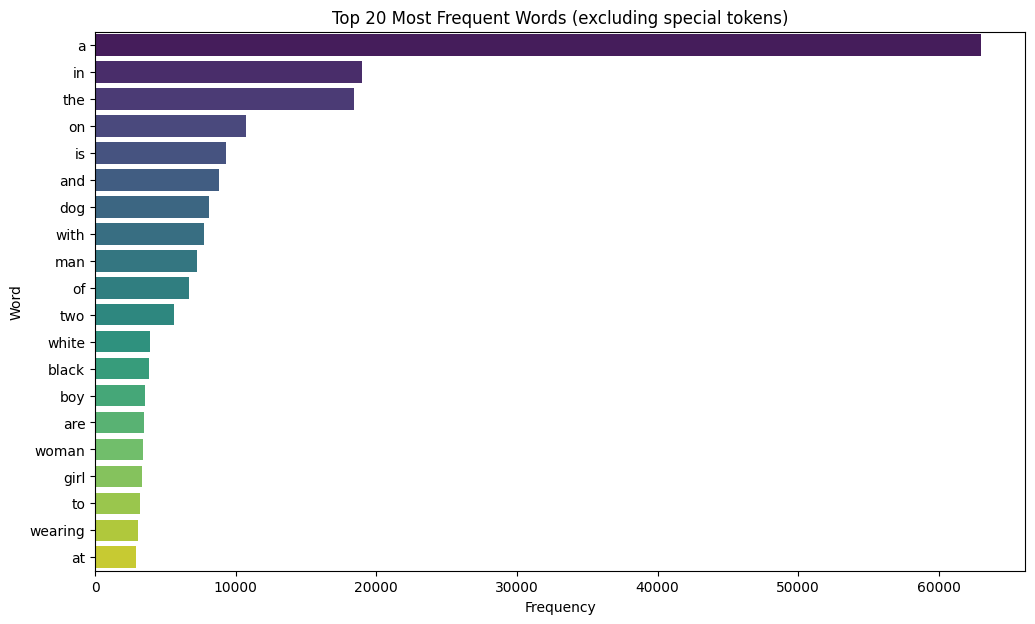

In [13]:
processor.plot_top_words(top_n=20)

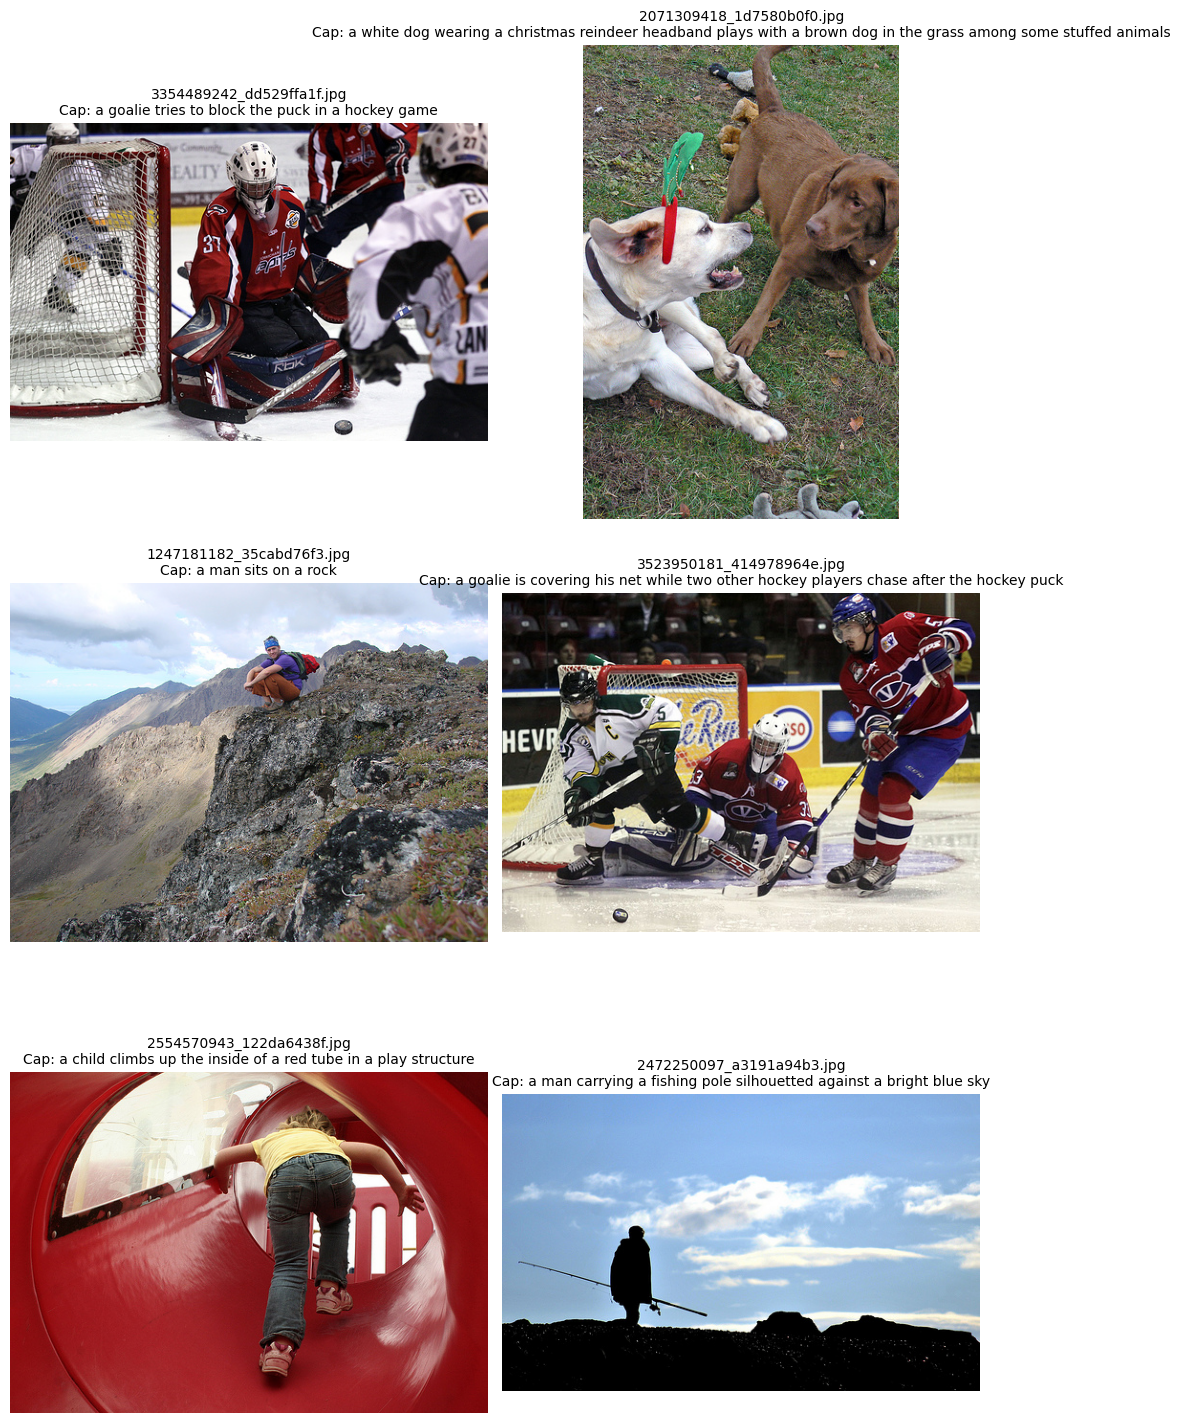

In [14]:
processor.plot_sample_images_with_caption(num_images=6)


#### Review of the built dataset


--- Displaying 2 Random Dataset Samples ---

--- Sample 1/2 ---
Image Name: 2419591925_1038c6c570.jpg


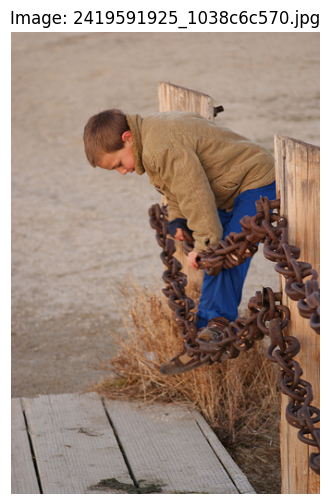

Ground Truth Captions:
  1. a boy in a brown jacket is standing on chains between two wooden posts
  2. a child standing on a heavy chain fence at a dock
  3. a little boy climbing over a chain fence
  4. a little boy standing and playing on a chained fence
  5. boy climbing on a chain fence

--- Sample 2/2 ---
Image Name: 2180480870_dcaf5ac0df.jpg


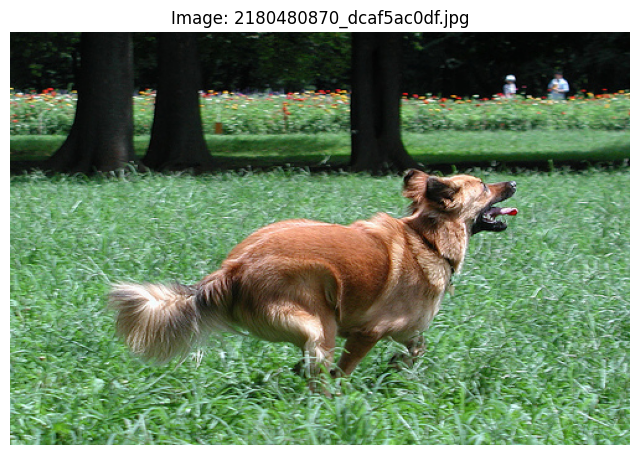

Ground Truth Captions:
  1. a brown dog is about to jump
  2. a dog runs through the grass
  3. a little brown dog running through a field of grass
  4. tan dog running through long grass in a parklike setting
  5. the large brownish dog is running through a grassy area


In [15]:
processor.display_samples(2)

#### Split dataset

In [16]:
processor.create_dataset_splits(train_ratio=0.85, val_ratio=0.1)

Train images: 6877, Val images: 809, Test images: 405
Train pairs: 34385, Val pairs: 4045, Test pairs: 2025


#### Feature extractor

In [17]:
feature_extractor_model = ImageFeatureExtractor()

In [18]:
cache_manager = ImageFeatureCacheManager(CONFIG, feature_extractor_model)
image_name_to_cached_path_map = cache_manager.manage_feature_cache(processor.image_paths)
final_train_data, final_val_data, final_test_data = processor.get_data_with_cached_features(image_name_to_cached_path_map)


Managing image feature cache in: /home/flickr8k/cache
Checking/extracting features for 8091 unique images.
All image features already cached. Skipping extraction.
Image feature cache management complete.
Adjusted train pairs (after feature caching check): 34385
Adjusted val pairs (after feature caching check): 4045
Adjusted test pairs (after feature caching check): 2025


#### Captioning model

In [19]:
trainer = ImageCaptioning(CONFIG, processor, feature_extractor_model)

Initializing from scratch.


In [20]:
trainer.summary()


--- Model Summaries ---

Encoder Model Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  196864    
                                                                 
Total params: 196,864
Trainable params: 196,864
Non-trainable params: 0
_________________________________________________________________

Decoder Model Summary:
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  765184    
                                                                 
 lstm (LSTM)                 multiple                  2099200   
                                                                 
 dense_1 (Dense)             multiple                  262656    
                             

### Captioning model training

In [21]:
trainer.train(final_train_data, processor.val_data)


Epoch 1/30 (Scheduled Sampling Prob: 0.000)
Epoch 1 Batch 0 Loss 2.4426
Epoch 1 Batch 100 Loss 1.7696
Epoch 1 Batch 200 Loss 1.7592
Epoch 1 Batch 300 Loss 1.5274
Epoch 1 Batch 400 Loss 1.5922
Epoch 1 Batch 500 Loss 1.7092
Epoch 1 Loss 1.7029

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


BLEU-1: 0.4905
BLEU-2: 0.2614
BLEU-3: 0.1295
BLEU-4: 0.0760
Saving checkpoint at epoch 1 with BLEU-4: 0.0760
Time taken for 1 epoch: 185.05 secs

Epoch 2/30 (Scheduled Sampling Prob: 0.007)
Epoch 2 Batch 0 Loss 1.6518
Epoch 2 Batch 100 Loss 1.4724
Epoch 2 Batch 200 Loss 1.5376
Epoch 2 Batch 300 Loss 1.5317
Epoch 2 Batch 400 Loss 1.3201
Epoch 2 Batch 500 Loss 1.3912
Epoch 2 Loss 1.4563

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:13<00:00, 13.52it/s]


BLEU-1: 0.5024
BLEU-2: 0.2784
BLEU-3: 0.1387
BLEU-4: 0.0769
Saving checkpoint at epoch 2 with BLEU-4: 0.0769
Time taken for 1 epoch: 151.29 secs

Epoch 3/30 (Scheduled Sampling Prob: 0.014)
Epoch 3 Batch 0 Loss 1.3806
Epoch 3 Batch 100 Loss 1.2641
Epoch 3 Batch 200 Loss 1.4688
Epoch 3 Batch 300 Loss 1.2897
Epoch 3 Batch 400 Loss 1.4019
Epoch 3 Batch 500 Loss 1.2159
Epoch 3 Loss 1.3200

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


BLEU-1: 0.1718
BLEU-2: 0.0959
BLEU-3: 0.0488
BLEU-4: 0.0264
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 250.76 secs

Epoch 4/30 (Scheduled Sampling Prob: 0.021)
Epoch 4 Batch 0 Loss 1.3208
Epoch 4 Batch 100 Loss 1.1973
Epoch 4 Batch 200 Loss 1.1927
Epoch 4 Batch 300 Loss 1.1678
Epoch 4 Batch 400 Loss 1.1680
Epoch 4 Batch 500 Loss 1.3030
Epoch 4 Loss 1.2451

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]


BLEU-1: 0.1854
BLEU-2: 0.1054
BLEU-3: 0.0563
BLEU-4: 0.0309
BLEU-4 not improved. Patience counter: 2/5
Time taken for 1 epoch: 240.46 secs

Epoch 5/30 (Scheduled Sampling Prob: 0.028)
Epoch 5 Batch 0 Loss 1.2445
Epoch 5 Batch 100 Loss 1.1600
Epoch 5 Batch 200 Loss 1.1414
Epoch 5 Batch 300 Loss 1.3975
Epoch 5 Batch 400 Loss 1.1578
Epoch 5 Batch 500 Loss 1.1871
Epoch 5 Loss 1.1961

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]


BLEU-1: 0.3968
BLEU-2: 0.2421
BLEU-3: 0.1285
BLEU-4: 0.0699
BLEU-4 not improved. Patience counter: 3/5
Time taken for 1 epoch: 186.39 secs

Epoch 6/30 (Scheduled Sampling Prob: 0.034)
Epoch 6 Batch 0 Loss 1.2290
Epoch 6 Batch 100 Loss 1.3102
Epoch 6 Batch 200 Loss 1.0929
Epoch 6 Batch 300 Loss 1.2931
Epoch 6 Batch 400 Loss 1.1999
Epoch 6 Batch 500 Loss 1.1168
Epoch 6 Loss 1.1582

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


BLEU-1: 0.4457
BLEU-2: 0.2790
BLEU-3: 0.1544
BLEU-4: 0.0874
Saving checkpoint at epoch 6 with BLEU-4: 0.0874
Time taken for 1 epoch: 173.44 secs

Epoch 7/30 (Scheduled Sampling Prob: 0.041)
Epoch 7 Batch 0 Loss 1.0690
Epoch 7 Batch 100 Loss 1.1393
Epoch 7 Batch 200 Loss 1.1366
Epoch 7 Batch 300 Loss 1.1554
Epoch 7 Batch 400 Loss 1.0969
Epoch 7 Batch 500 Loss 1.2389
Epoch 7 Loss 1.1263

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


BLEU-1: 0.4064
BLEU-2: 0.2529
BLEU-3: 0.1394
BLEU-4: 0.0802
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 182.77 secs

Epoch 8/30 (Scheduled Sampling Prob: 0.048)
Epoch 8 Batch 0 Loss 1.1652
Epoch 8 Batch 100 Loss 1.1200
Epoch 8 Batch 200 Loss 1.0505
Epoch 8 Batch 300 Loss 1.0342
Epoch 8 Batch 400 Loss 1.0606
Epoch 8 Batch 500 Loss 1.1457
Epoch 8 Loss 1.0992

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


BLEU-1: 0.4508
BLEU-2: 0.2821
BLEU-3: 0.1608
BLEU-4: 0.0943
Saving checkpoint at epoch 8 with BLEU-4: 0.0943
Time taken for 1 epoch: 168.42 secs

Epoch 9/30 (Scheduled Sampling Prob: 0.055)
Epoch 9 Batch 0 Loss 1.1027
Epoch 9 Batch 100 Loss 1.1039
Epoch 9 Batch 200 Loss 1.0633
Epoch 9 Batch 300 Loss 1.0698
Epoch 9 Batch 400 Loss 1.1069
Epoch 9 Batch 500 Loss 1.1042
Epoch 9 Loss 1.0752

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:36<00:00, 10.35it/s]


BLEU-1: 0.4405
BLEU-2: 0.2809
BLEU-3: 0.1620
BLEU-4: 0.0969
Saving checkpoint at epoch 9 with BLEU-4: 0.0969
Time taken for 1 epoch: 175.00 secs

Epoch 10/30 (Scheduled Sampling Prob: 0.062)
Epoch 10 Batch 0 Loss 1.0836
Epoch 10 Batch 100 Loss 0.9788
Epoch 10 Batch 200 Loss 0.9392
Epoch 10 Batch 300 Loss 0.9973
Epoch 10 Batch 400 Loss 1.1900
Epoch 10 Batch 500 Loss 0.9779
Epoch 10 Loss 1.0540

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


BLEU-1: 0.4048
BLEU-2: 0.2557
BLEU-3: 0.1495
BLEU-4: 0.0890
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 177.87 secs

Epoch 11/30 (Scheduled Sampling Prob: 0.069)
Epoch 11 Batch 0 Loss 0.9531
Epoch 11 Batch 100 Loss 1.1048
Epoch 11 Batch 200 Loss 1.0430
Epoch 11 Batch 300 Loss 0.9498
Epoch 11 Batch 400 Loss 1.0370
Epoch 11 Batch 500 Loss 0.9928
Epoch 11 Loss 1.0350

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


BLEU-1: 0.5532
BLEU-2: 0.3632
BLEU-3: 0.2239
BLEU-4: 0.1398
Saving checkpoint at epoch 11 with BLEU-4: 0.1398
Time taken for 1 epoch: 155.89 secs

Epoch 12/30 (Scheduled Sampling Prob: 0.076)
Epoch 12 Batch 0 Loss 0.9700
Epoch 12 Batch 100 Loss 0.9639
Epoch 12 Batch 200 Loss 1.0369
Epoch 12 Batch 300 Loss 1.0268
Epoch 12 Batch 400 Loss 0.9740
Epoch 12 Batch 500 Loss 1.0910
Epoch 12 Loss 1.0178

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]


BLEU-1: 0.4088
BLEU-2: 0.2658
BLEU-3: 0.1622
BLEU-4: 0.1003
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 181.63 secs

Epoch 13/30 (Scheduled Sampling Prob: 0.083)
Epoch 13 Batch 0 Loss 0.9846
Epoch 13 Batch 100 Loss 1.0963
Epoch 13 Batch 200 Loss 1.0287
Epoch 13 Batch 300 Loss 0.9734
Epoch 13 Batch 400 Loss 0.9690
Epoch 13 Batch 500 Loss 0.9996
Epoch 13 Loss 1.0023

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


BLEU-1: 0.5023
BLEU-2: 0.3333
BLEU-3: 0.2096
BLEU-4: 0.1334
BLEU-4 not improved. Patience counter: 2/5
Time taken for 1 epoch: 164.21 secs

Epoch 14/30 (Scheduled Sampling Prob: 0.090)
Epoch 14 Batch 0 Loss 0.9957
Epoch 14 Batch 100 Loss 1.0450
Epoch 14 Batch 200 Loss 1.0884
Epoch 14 Batch 300 Loss 1.0082
Epoch 14 Batch 400 Loss 0.9788
Epoch 14 Batch 500 Loss 0.9883
Epoch 14 Loss 0.9881

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]


BLEU-1: 0.5392
BLEU-2: 0.3627
BLEU-3: 0.2306
BLEU-4: 0.1458
Saving checkpoint at epoch 14 with BLEU-4: 0.1458
Time taken for 1 epoch: 159.58 secs

Epoch 15/30 (Scheduled Sampling Prob: 0.097)
Epoch 15 Batch 0 Loss 0.9164
Epoch 15 Batch 100 Loss 0.8725
Epoch 15 Batch 200 Loss 0.9336
Epoch 15 Batch 300 Loss 0.9717
Epoch 15 Batch 400 Loss 0.9255
Epoch 15 Batch 500 Loss 0.8909
Epoch 15 Loss 0.9751

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


BLEU-1: 0.4835
BLEU-2: 0.3227
BLEU-3: 0.2025
BLEU-4: 0.1289
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 169.73 secs

Epoch 16/30 (Scheduled Sampling Prob: 0.103)
Epoch 16 Batch 0 Loss 0.9986
Epoch 16 Batch 100 Loss 0.9109
Epoch 16 Batch 200 Loss 1.0238
Epoch 16 Batch 300 Loss 0.9110
Epoch 16 Batch 400 Loss 0.9674
Epoch 16 Batch 500 Loss 0.9651
Epoch 16 Loss 0.9624

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


BLEU-1: 0.5169
BLEU-2: 0.3477
BLEU-3: 0.2219
BLEU-4: 0.1442
BLEU-4 not improved. Patience counter: 2/5
Time taken for 1 epoch: 168.71 secs

Epoch 17/30 (Scheduled Sampling Prob: 0.110)
Epoch 17 Batch 0 Loss 0.8729
Epoch 17 Batch 100 Loss 0.9663
Epoch 17 Batch 200 Loss 0.9076
Epoch 17 Batch 300 Loss 0.9991
Epoch 17 Batch 400 Loss 1.0077
Epoch 17 Batch 500 Loss 0.9918
Epoch 17 Loss 0.9511

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


BLEU-1: 0.5234
BLEU-2: 0.3551
BLEU-3: 0.2291
BLEU-4: 0.1479
Saving checkpoint at epoch 17 with BLEU-4: 0.1479
Time taken for 1 epoch: 164.88 secs

Epoch 18/30 (Scheduled Sampling Prob: 0.117)
Epoch 18 Batch 0 Loss 0.9016
Epoch 18 Batch 100 Loss 1.0092
Epoch 18 Batch 200 Loss 0.9273
Epoch 18 Batch 300 Loss 0.9581
Epoch 18 Batch 400 Loss 0.9218
Epoch 18 Batch 500 Loss 0.8578
Epoch 18 Loss 0.9403

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


BLEU-1: 0.5252
BLEU-2: 0.3609
BLEU-3: 0.2350
BLEU-4: 0.1532
Saving checkpoint at epoch 18 with BLEU-4: 0.1532
Time taken for 1 epoch: 163.81 secs

Epoch 19/30 (Scheduled Sampling Prob: 0.124)
Epoch 19 Batch 0 Loss 0.8388
Epoch 19 Batch 100 Loss 0.9131
Epoch 19 Batch 200 Loss 0.8788
Epoch 19 Batch 300 Loss 0.9858
Epoch 19 Batch 400 Loss 0.8710
Epoch 19 Batch 500 Loss 0.9373
Epoch 19 Loss 0.9302

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:32<00:00, 10.79it/s]


BLEU-1: 0.5310
BLEU-2: 0.3650
BLEU-3: 0.2426
BLEU-4: 0.1591
Saving checkpoint at epoch 19 with BLEU-4: 0.1591
Time taken for 1 epoch: 169.87 secs

Epoch 20/30 (Scheduled Sampling Prob: 0.131)
Epoch 20 Batch 0 Loss 0.8849
Epoch 20 Batch 100 Loss 0.9052
Epoch 20 Batch 200 Loss 0.8216
Epoch 20 Batch 300 Loss 1.0032
Epoch 20 Batch 400 Loss 0.9197
Epoch 20 Batch 500 Loss 0.8985
Epoch 20 Loss 0.9210

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


BLEU-1: 0.5392
BLEU-2: 0.3730
BLEU-3: 0.2459
BLEU-4: 0.1611
Saving checkpoint at epoch 20 with BLEU-4: 0.1611
Time taken for 1 epoch: 165.56 secs

Epoch 21/30 (Scheduled Sampling Prob: 0.138)
Epoch 21 Batch 0 Loss 0.9507
Epoch 21 Batch 100 Loss 0.8942
Epoch 21 Batch 200 Loss 0.8815
Epoch 21 Batch 300 Loss 0.9158
Epoch 21 Batch 400 Loss 0.9533
Epoch 21 Batch 500 Loss 0.9121
Epoch 21 Loss 0.9119

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


BLEU-1: 0.5547
BLEU-2: 0.3835
BLEU-3: 0.2515
BLEU-4: 0.1643
Saving checkpoint at epoch 21 with BLEU-4: 0.1643
Time taken for 1 epoch: 162.25 secs

Epoch 22/30 (Scheduled Sampling Prob: 0.145)
Epoch 22 Batch 0 Loss 0.9925
Epoch 22 Batch 100 Loss 0.9126
Epoch 22 Batch 200 Loss 0.8853
Epoch 22 Batch 300 Loss 0.9213
Epoch 22 Batch 400 Loss 0.9839
Epoch 22 Batch 500 Loss 0.8292
Epoch 22 Loss 0.9032

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


BLEU-1: 0.5607
BLEU-2: 0.3849
BLEU-3: 0.2540
BLEU-4: 0.1678
Saving checkpoint at epoch 22 with BLEU-4: 0.1678
Time taken for 1 epoch: 162.37 secs

Epoch 23/30 (Scheduled Sampling Prob: 0.152)
Epoch 23 Batch 0 Loss 0.9299
Epoch 23 Batch 100 Loss 0.8909
Epoch 23 Batch 200 Loss 0.9882
Epoch 23 Batch 300 Loss 0.8795
Epoch 23 Batch 400 Loss 0.8730
Epoch 23 Batch 500 Loss 0.9202
Epoch 23 Loss 0.8950

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.57it/s]


BLEU-1: 0.5483
BLEU-2: 0.3802
BLEU-3: 0.2517
BLEU-4: 0.1648
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 164.86 secs

Epoch 24/30 (Scheduled Sampling Prob: 0.159)
Epoch 24 Batch 0 Loss 0.8400
Epoch 24 Batch 100 Loss 0.8472
Epoch 24 Batch 200 Loss 0.9283
Epoch 24 Batch 300 Loss 0.9385
Epoch 24 Batch 400 Loss 0.9274
Epoch 24 Batch 500 Loss 0.8969
Epoch 24 Loss 0.8873

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


BLEU-1: 0.5562
BLEU-2: 0.3787
BLEU-3: 0.2459
BLEU-4: 0.1584
BLEU-4 not improved. Patience counter: 2/5
Time taken for 1 epoch: 163.89 secs

Epoch 25/30 (Scheduled Sampling Prob: 0.166)
Epoch 25 Batch 0 Loss 0.9508
Epoch 25 Batch 100 Loss 0.8497
Epoch 25 Batch 200 Loss 0.8600
Epoch 25 Batch 300 Loss 0.9304
Epoch 25 Batch 400 Loss 0.8292
Epoch 25 Batch 500 Loss 0.8724
Epoch 25 Loss 0.8794

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


BLEU-1: 0.5594
BLEU-2: 0.3867
BLEU-3: 0.2560
BLEU-4: 0.1701
Saving checkpoint at epoch 25 with BLEU-4: 0.1701
Time taken for 1 epoch: 159.20 secs

Epoch 26/30 (Scheduled Sampling Prob: 0.172)
Epoch 26 Batch 0 Loss 0.8304
Epoch 26 Batch 100 Loss 0.8410
Epoch 26 Batch 200 Loss 0.8639
Epoch 26 Batch 300 Loss 0.7453
Epoch 26 Batch 400 Loss 0.9573
Epoch 26 Batch 500 Loss 0.7882
Epoch 26 Loss 0.8722

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:22<00:00, 12.08it/s]


BLEU-1: 0.5796
BLEU-2: 0.4005
BLEU-3: 0.2632
BLEU-4: 0.1751
Saving checkpoint at epoch 26 with BLEU-4: 0.1751
Time taken for 1 epoch: 155.49 secs

Epoch 27/30 (Scheduled Sampling Prob: 0.179)
Epoch 27 Batch 0 Loss 0.8596
Epoch 27 Batch 100 Loss 0.8278
Epoch 27 Batch 200 Loss 0.8833
Epoch 27 Batch 300 Loss 0.8042
Epoch 27 Batch 400 Loss 0.8235
Epoch 27 Batch 500 Loss 0.9700
Epoch 27 Loss 0.8651

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]


BLEU-1: 0.5473
BLEU-2: 0.3740
BLEU-3: 0.2452
BLEU-4: 0.1619
BLEU-4 not improved. Patience counter: 1/5
Time taken for 1 epoch: 163.98 secs

Epoch 28/30 (Scheduled Sampling Prob: 0.186)
Epoch 28 Batch 0 Loss 0.8639
Epoch 28 Batch 100 Loss 0.8163
Epoch 28 Batch 200 Loss 0.8558
Epoch 28 Batch 300 Loss 0.8324
Epoch 28 Batch 400 Loss 0.8471
Epoch 28 Batch 500 Loss 0.9105
Epoch 28 Loss 0.8582

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.24it/s]


BLEU-1: 0.5749
BLEU-2: 0.3899
BLEU-3: 0.2561
BLEU-4: 0.1683
BLEU-4 not improved. Patience counter: 2/5
Time taken for 1 epoch: 156.17 secs

Epoch 29/30 (Scheduled Sampling Prob: 0.193)
Epoch 29 Batch 0 Loss 0.9488
Epoch 29 Batch 100 Loss 0.7920
Epoch 29 Batch 200 Loss 0.8386
Epoch 29 Batch 300 Loss 0.8609
Epoch 29 Batch 400 Loss 0.8115
Epoch 29 Batch 500 Loss 0.8857
Epoch 29 Loss 0.8516

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


BLEU-1: 0.5631
BLEU-2: 0.3853
BLEU-3: 0.2539
BLEU-4: 0.1676
BLEU-4 not improved. Patience counter: 3/5
Time taken for 1 epoch: 163.71 secs

Epoch 30/30 (Scheduled Sampling Prob: 0.200)
Epoch 30 Batch 0 Loss 0.8365
Epoch 30 Batch 100 Loss 0.7733
Epoch 30 Batch 200 Loss 0.8540
Epoch 30 Batch 300 Loss 0.9381
Epoch 30 Batch 400 Loss 0.7697
Epoch 30 Batch 500 Loss 0.8035
Epoch 30 Loss 0.8450

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]


BLEU-1: 0.5587
BLEU-2: 0.3822
BLEU-3: 0.2554
BLEU-4: 0.1682
BLEU-4 not improved. Patience counter: 4/5
Time taken for 1 epoch: 161.20 secs


#### Additional training runs

In [ ]:
CONFIG['epochs'] = 40
print(f"Continuing training for a new total of {CONFIG['epochs']} epochs.")
print("The model will restore from the latest checkpoint and proceed.")
trainer.train(final_train_data, processor.val_data)

In [ ]:
CONFIG['epochs'] = 50
print(f"Continuing training for a new total of {CONFIG['epochs']} epochs.")
print("The model will restore from the latest checkpoint and proceed.")
trainer.train(final_train_data, processor.val_data)

#### Captioning model evaluation

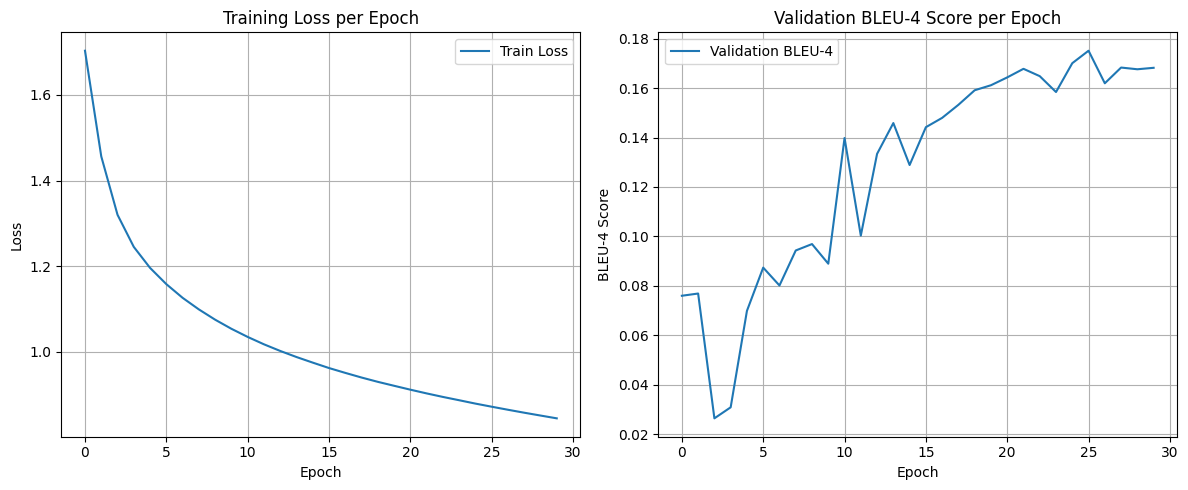

In [22]:
trainer.plot_history()

#### BLEU score on test

In [23]:
trainer.evaluate_bleu_score(processor.test_data)


Evaluating BLEU on 2025 samples...


100%|██████████| 2025/2025 [03:02<00:00, 11.12it/s]


BLEU-1: 0.5441
BLEU-2: 0.3729
BLEU-3: 0.2426
BLEU-4: 0.1575


{'bleu-1': 0.5440988495952279,
 'bleu-2': 0.3728774825106511,
 'bleu-3': 0.24262860245239348,
 'bleu-4': 0.15753088218041797}

#### Predictions on test

In [24]:
trainer.run_predictions(processor.test_data, num_samples=10)


--- Running Predictions for 10 Random Samples ---

--- Prediction Sample 1/10 (Image: 2595713720_30534e8de2.jpg) ---
Ground Truth Captions:
  1. a girl in a cowboy hat with a sheep on a leash
  2. a girl wearing a pink hat is walking beside a sheep on a dusty path
  3. a little girl in a pink cowgirl hat and blue cast over her arm is walking a sheep
  4. a young girl wearing a pink cowboy hat holding a sheep on a leash
  5. the girl is wearing a pink cowgirl hat and pink boots
Generated Caption (Beam Search): a little girl and a little girl are sitting on the sidewalk
Prediction Time: 783.20 ms

--- Prediction Sample 2/10 (Image: 2850719435_221f15e951.jpg) ---
Ground Truth Captions:
  1. a boy in a red shirt and a boy in a yellow shirt are jumping on a trampoline outside
  2. children jump on a trampoline
  3. kids are jumping on a blue rimmed trampoline
  4. two children are playing on a teal trampoline near greenery
  5. two young boys jumps on a trampoline as two other children sit

#### Captioning model demo

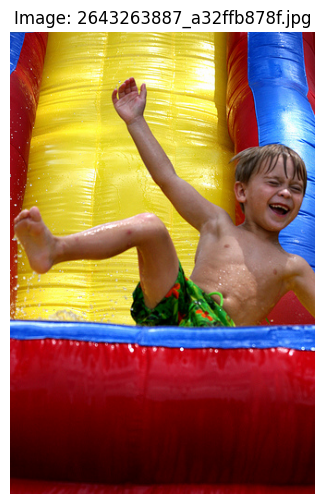


Ground Truth Captions:
  1. a boy going down a water slide
  2. a boy in green trunks slides down a water slide
  3. a boy slides down an inflatable water slide
  4. a child reaches the bottom of an inflatable slide
  5. a young boy smiling as he rides down an inflatable water slide

Generated Caption (Beam Search): a young boy in a swimming pool is playing in a pool

Playing generated caption:


Audio saved to caption_audio_2643263887_a32ffb878f.mp3 and played.


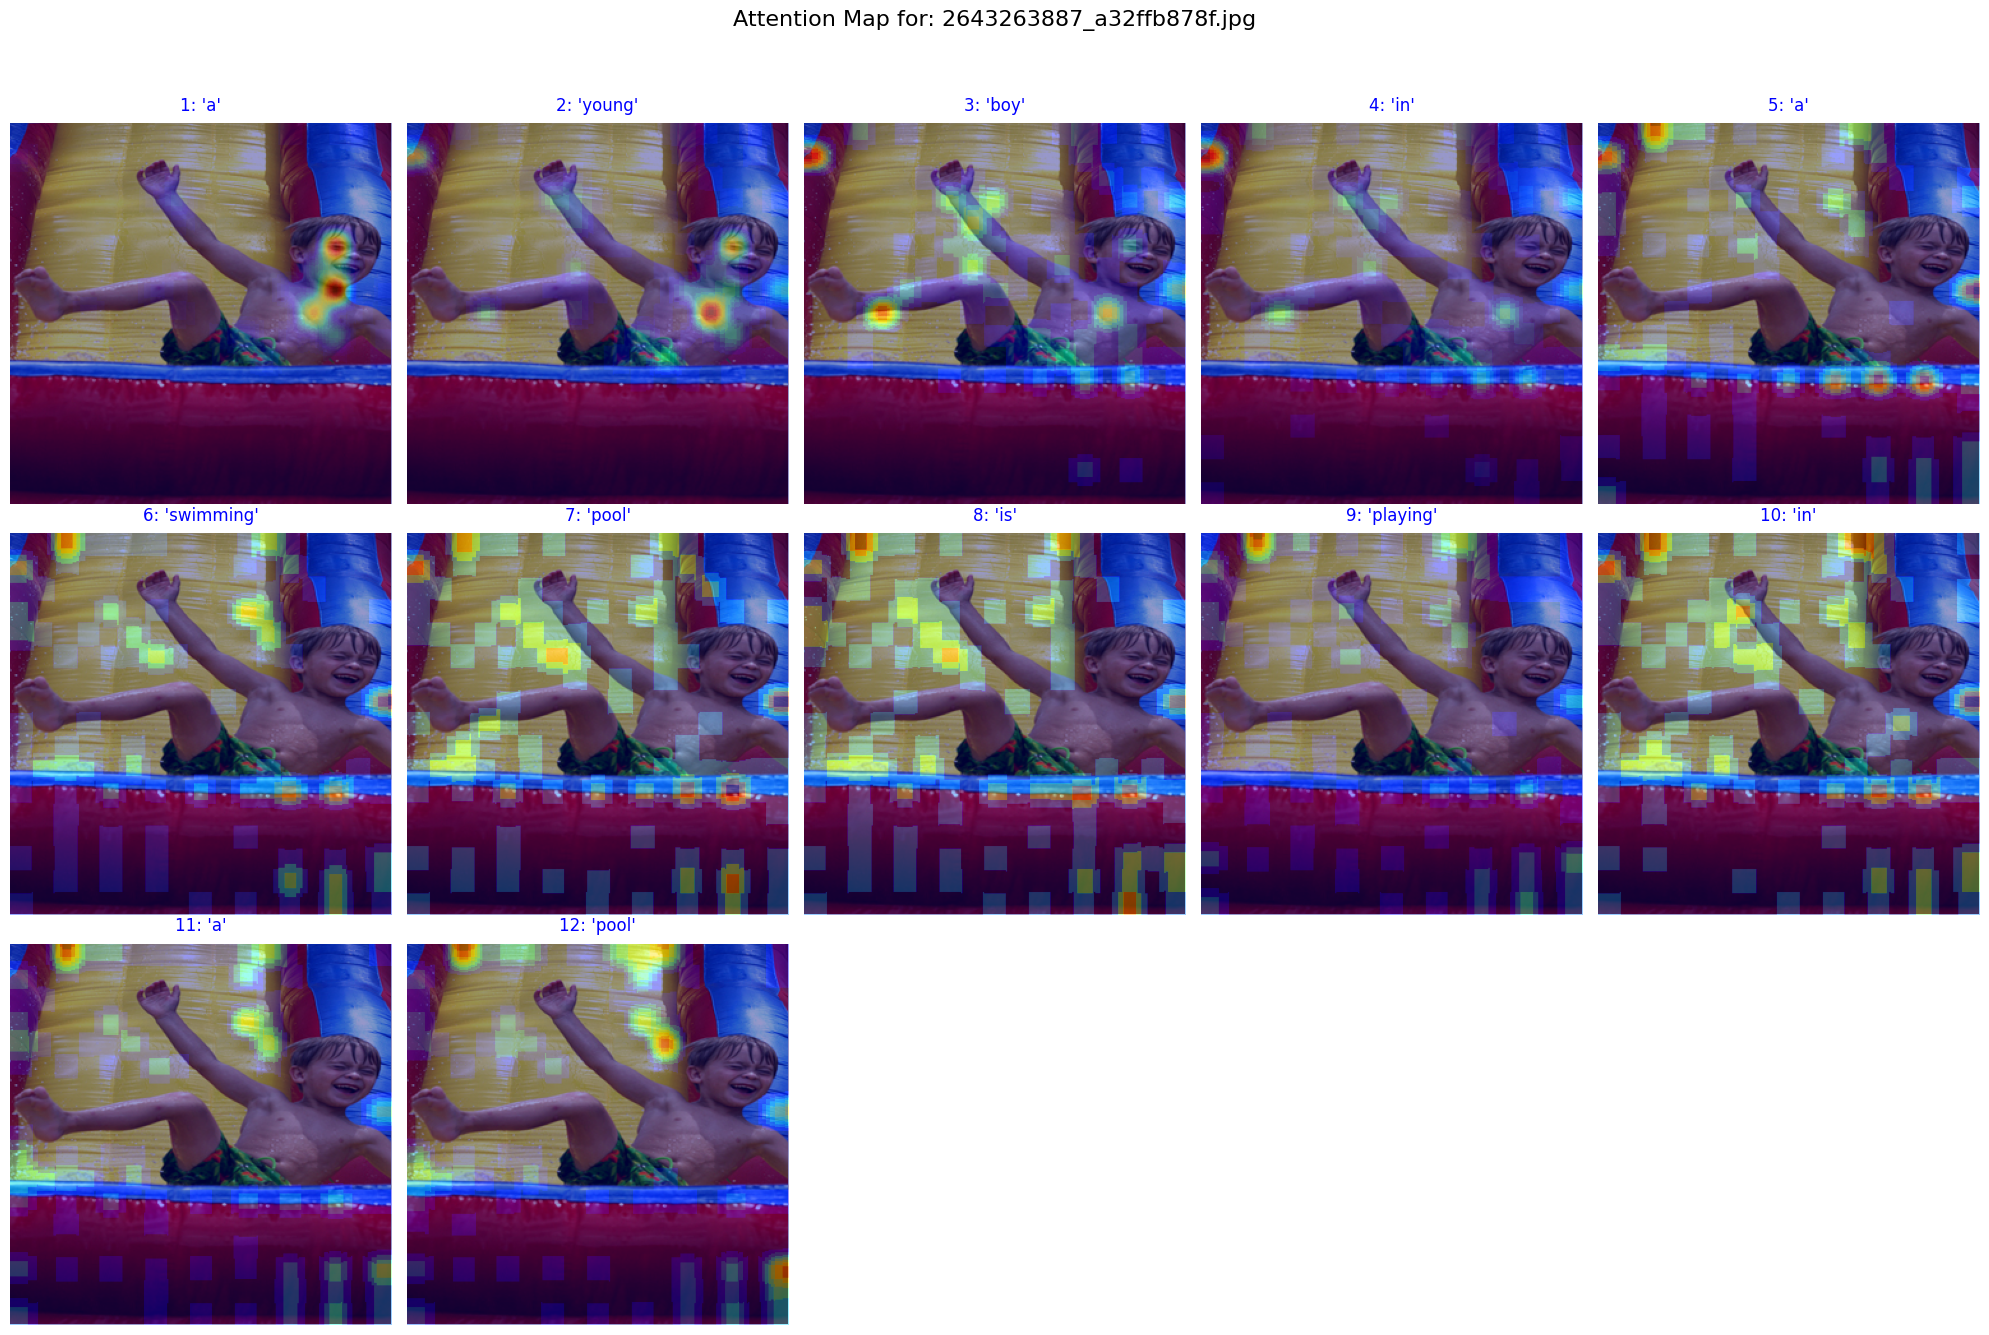

In [25]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    trainer.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

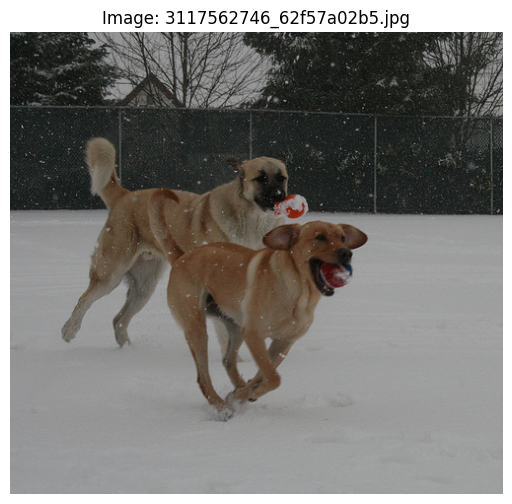


Ground Truth Captions:
  1. a dog chases another dog
  2. two dogs are running through the snow with ball in their mouths
  3. two dogs holding red balls in their mouth running in the snow
  4. two dogs in the snow
  5. two tan dogs run in the snow carrying red balls in their mouths

Generated Caption (Beam Search): a brown dog and a brown dog are playing in the snow

Playing generated caption:


Audio saved to caption_audio_3117562746_62f57a02b5.mp3 and played.


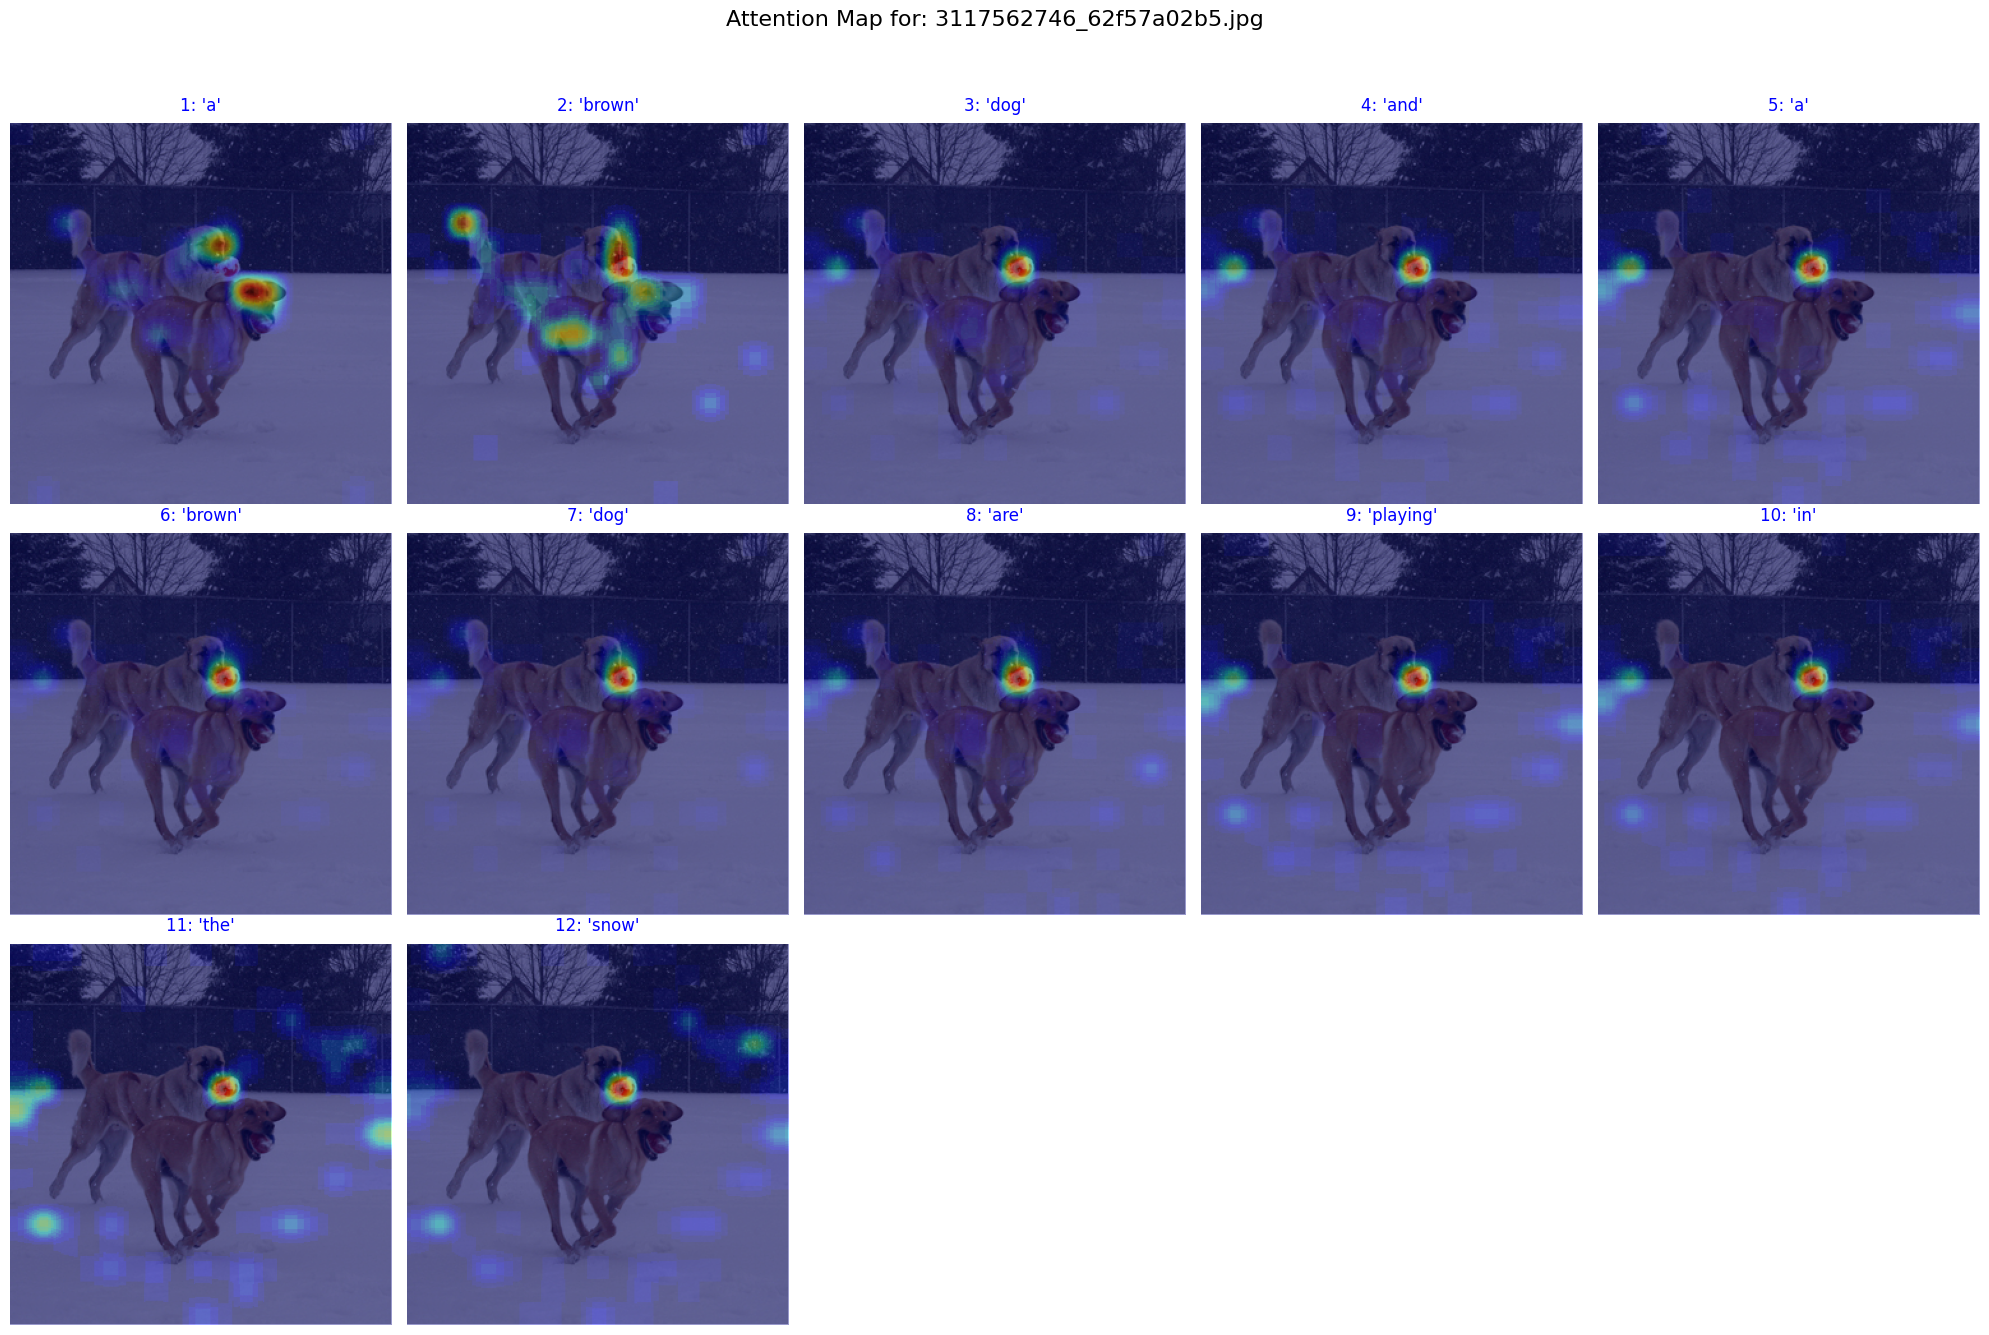

In [26]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    trainer.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

### Comparision with other notable work with Flickr-8k

| Model / Paper (Flickr-8k test split) | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 |
|-------------------------------------|:------:|:------:|:------:|:------:|
| **My best checkpoint (Attn)**      | ▢      | ▢      | ▢      | ▢      |
| Xu et al., 2015 — *Soft-Attention*  | 0.67 | 0.448 | 0.299 | 0.195  |
| Xu et al., 2015 — *Hard-Attention*  | 0.67 | 0.457 | 0.314 | 0.213  |
| Google NIC (Vinyals et al., 2015)   | 0.63 | 0.41  | 0.27  | 0.160* |

* BLEU-4 for NIC comes from a later re-implementation that reports full n-gram scores on the official Flickr-8k split.


[^1]: Kelvin Xu, Jimmy Lei Ba, Ryan Kiros, Kyunghyun Cho, Aaron Courville,  
      Ruslan Salakhutdinov, Richard Zemel & Yoshua Bengio.  
      *Show, Attend and Tell: Neural Image Caption Generation with Visual Attention*.  
      Proceedings of the 32nd International Conference on Machine Learning (ICML 2015),  
      PMLR 37, pp. 2048–2057. :contentReference[oaicite:0]{index=0}

[^2]: Oriol Vinyals, Alexander Toshev, Samy Bengio & Dumitru Erhan.  
      *Show and Tell: A Neural Image Caption Generator*.  
      Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR 2015),  
      pp. 3156–3164. DOI 10.1109/CVPR.2015.7298935. :contentReference[oaicite:1]{index=1}
